In [1]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import L2
import tensorflow.keras.callbacks
import tensorflow.keras.utils as ku 
import numpy as np 

In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt \
    -O /tmp/irish-lyrics-eof.txt
data_irish = open('/tmp/irish-lyrics-eof.txt').read()

--2020-09-05 14:47:04--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/irish-lyrics-eof.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68970 (67K) [text/plain]
Saving to: ‘/tmp/irish-lyrics-eof.txt’

/tmp/irish-lyrics-e 100%[===================>]  67.35K  --.-KB/s    in 0s      

2020-09-05 14:47:04 (143 MB/s) - ‘/tmp/irish-lyrics-eof.txt’ saved [68970/68970]



In [3]:
tokenizer_irish = Tokenizer()

corpus_irish = data_irish.lower().split("\n")

tokenizer_irish.fit_on_texts(corpus_irish)
total_words_irish = len(tokenizer_irish.word_index) + 1

# create input sequences using list of tokens
input_sequences_irish = []
for line in corpus_irish:
	token_list = tokenizer_irish.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences_irish.append(n_gram_sequence)


# pad sequences 
max_sequence_len_irish = max([len(x) for x in input_sequences_irish])
input_sequences_irish = np.array(pad_sequences(input_sequences_irish, maxlen=max_sequence_len_irish, padding='pre'))

# create predictors and label
predictors_irish, label_irish = input_sequences_irish[:,:-1],input_sequences_irish[:,-1]

label_irish = ku.to_categorical(label_irish, num_classes=total_words_irish)

In [4]:
tokenizer_irish.word_index['meadow']

945

In [5]:
print(max_sequence_len_irish)

16


In [6]:
total_words_irish

2690

In [7]:
label_irish[:20]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [8]:
model_irish = Sequential()
model_irish.add(Embedding(total_words_irish, 100, input_length=max_sequence_len_irish-1))
model_irish.add(Bidirectional(LSTM(150)))
#model_irish.add(Dropout(0.2))
#model_irish.add(LSTM(100))
#model_irish.add(Dense(32, kernel_regularizer=L2(0.01), activation='relu'))
model_irish.add(Dense(total_words_irish, activation='softmax'))

optimizer = Adam(lr=0.01)

model_irish.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print(model_irish.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 15, 100)           269000    
_________________________________________________________________
bidirectional (Bidirectional (None, 300)               301200    
_________________________________________________________________
dense (Dense)                (None, 2690)              809690    
Total params: 1,379,890
Trainable params: 1,379,890
Non-trainable params: 0
_________________________________________________________________
None


In [9]:
lr_schedule = tensorflow.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-5 * 10**(epoch / 20))

In [10]:
history_irish = model_irish.fit(predictors_irish, label_irish, epochs=80, verbose=1, 
                                #callbacks=[lr_schedule]
                                )

Epoch 1/80
377/377 [==============================] - 4s 9ms/step - loss: 6.6160 - accuracy: 0.0763
Epoch 2/80
377/377 [==============================] - 4s 9ms/step - loss: 5.7412 - accuracy: 0.1189
Epoch 3/80
377/377 [==============================] - 3s 9ms/step - loss: 4.8793 - accuracy: 0.1645
Epoch 4/80
377/377 [==============================] - 4s 9ms/step - loss: 3.9680 - accuracy: 0.2383
Epoch 5/80
377/377 [==============================] - 4s 9ms/step - loss: 3.1537 - accuracy: 0.3313
Epoch 6/80
377/377 [==============================] - 3s 9ms/step - loss: 2.4710 - accuracy: 0.4443
Epoch 7/80
377/377 [==============================] - 3s 9ms/step - loss: 1.9750 - accuracy: 0.5392
Epoch 8/80
377/377 [==============================] - 3s 9ms/step - loss: 1.6143 - accuracy: 0.6187
Epoch 9/80
377/377 [==============================] - 3s 9ms/step - loss: 1.3785 - accuracy: 0.6685
Epoch 10/80
377/377 [==============================] - 3s 9ms/step - loss: 1.1812 - accuracy: 0.7142

In [11]:
import matplotlib.pyplot as plt

"""plt.semilogx(history_irish.history["lr"], history_irish.history["loss"])
plt.axis([1e-3, 4e-2, 0, 6])"""

'plt.semilogx(history_irish.history["lr"], history_irish.history["loss"])\nplt.axis([1e-3, 4e-2, 0, 6])'

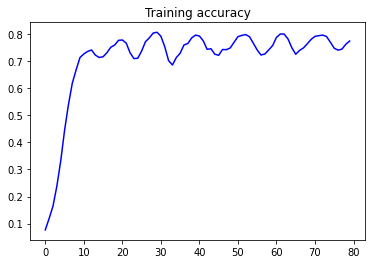

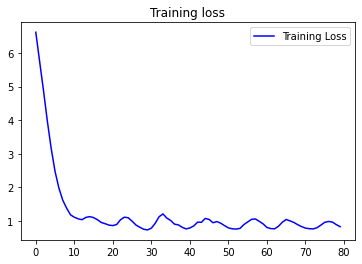

In [12]:
acc = history_irish.history['accuracy']
loss = history_irish.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

In [13]:
seed_text = "Oh my dear, I"
next_words = 50
  
for _ in range(next_words):
	token_list = tokenizer_irish.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len_irish-1, padding='pre')
	predicted = model_irish.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer_irish.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
Oh my dear, I was going to derry quay provost and laid her hand on the cliffs of doneen gone wont young odd round his honor down so duram on around the gate first man doesnt were gone gone over the way of neer come and awake make the love in your long must


In [14]:
model_irish.save('irish_model.h5') 

In [15]:
try:
  from google.colab import files
except ImportError:
  pass
else:
  files.download('irish_model.h5')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>